In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Set dataset path
dataset_path = r"Dataset"

In [3]:
# Load dataset
img_size = (224, 224)
batch_size = 32


In [4]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

Found 400 files belonging to 4 classes.
Using 320 files for training.


In [5]:
val_ds = keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

Found 400 files belonging to 4 classes.
Using 80 files for validation.


In [6]:
class_names = train_ds.class_names  # Get class labels

# Normalize the images
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [7]:
# Define the MobileNet model
base_model = keras.applications.MobileNetV2(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False
)

base_model.trainable = False  # Freeze the base model

# Add custom layers
global_avg_layer = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(len(class_names), activation='softmax')

# Build the model
model = keras.Sequential([
    base_model,
    global_avg_layer,
    output_layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

# Save the trained model
model.save("mushroom_mobilenet_model.h5")
print("Model saved successfully!")

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.3728 - loss: 1.4266 - val_accuracy: 0.8375 - val_loss: 0.6961
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8557 - loss: 0.5792 - val_accuracy: 0.9625 - val_loss: 0.3458
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9332 - loss: 0.3176 - val_accuracy: 0.9625 - val_loss: 0.2652
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9582 - loss: 0.2175 - val_accuracy: 0.9750 - val_loss: 0.1927
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9770 - loss: 0.1487 - val_accuracy: 0.9750 - val_loss: 0.1732
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9893 - loss: 0.1113 - val_accuracy: 0.9750 - val_loss: 0.1627
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9873 - loss: 0.1026 - val_accuracy: 0.9750 - val_loss: 0.1598
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9952 - loss: 0.0819 - val_accuracy: 0.9750 - val_loss:

Model saved successfully!


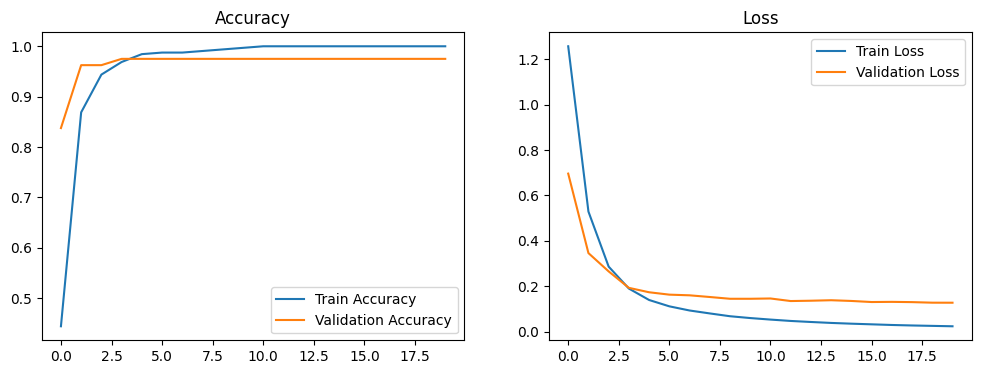

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


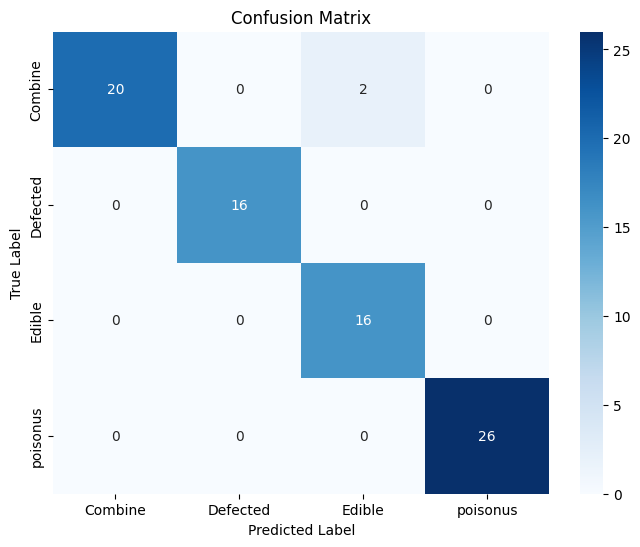

Classification Report:
               precision    recall  f1-score   support

     Combine       1.00      0.91      0.95        22
    Defected       1.00      1.00      1.00        16
      Edible       0.89      1.00      0.94        16
    poisonus       1.00      1.00      1.00        26

    accuracy                           0.97        80
   macro avg       0.97      0.98      0.97        80
weighted avg       0.98      0.97      0.98        80



In [8]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

# Generate Confusion Matrix
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())  
    y_pred.extend(np.argmax(preds, axis=1))  

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
